In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
pd.options.mode.chained_assignment = None 
pd.set_option("display.max_rows",20)

In [5]:
os.chdir('/Users/gaoteng/Desktop/dataOpen')

weather data processing

In [6]:
weathers = pd.read_csv('../dataOpen/weather.csv')
# only take date
weathers['timepoint'] = weathers.datetime.str.slice(0,10)
# get a location dictionary of airports
airport_coords = weathers[['airport_id', 'latitude', 'longitude']].groupby('airport_id')\
.agg({'latitude': lambda lats: set(lats), 'longitude': lambda longs: set(longs)})
# airport_coords['lat'] = airport_coords.latitude.apply(lambda x: sum(x)/2)
# airport_coords['long'] = airport_coords.longitude.apply(lambda x: )
airport_coords['latitude'] = airport_coords.latitude.apply(lambda x: x.pop())
airport_coords['longitude'] = airport_coords.longitude.apply(lambda x: x.pop())
airport_coords['airport_id'] = airport_coords.index
weathers = pd.merge(airport_coords, weathers, on = 'airport_id', how = 'inner')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: 'airport_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
weathers['spacetime'] = weathers.apply(lambda row: (row.airport_id, row.timepoint), axis = 1)

In [8]:
# take the mean of the weather data for each day
weathers = weathers.groupby('spacetime') \
.agg({'wind_speed': np.mean, \
      'temperature': np.mean})
weathers['timepoint'] = weathers.index

In [229]:
weathers

,wind_speed,temperature,timepoint
spacetime,,,
"(ABE, 2017-01-01)",3.725,6.250,"(ABE, 2017-01-01)"
"(ABE, 2017-01-02)",1.300,0.425,"(ABE, 2017-01-02)"
"(ABE, 2017-01-03)",3.975,3.350,"(ABE, 2017-01-03)"
"(ABE, 2017-01-04)",3.225,6.375,"(ABE, 2017-01-04)"
"(ABE, 2017-01-05)",5.775,-1.400,"(ABE, 2017-01-05)"
"(ABE, 2017-01-06)",2.825,-2.350,"(ABE, 2017-01-06)"
"(ABE, 2017-01-07)",2.300,-4.875,"(ABE, 2017-01-07)"
"(ABE, 2017-01-08)",5.900,-7.075,"(ABE, 2017-01-08)"
"(ABE, 2017-01-09)",2.825,-8.050,"(ABE, 2017-01-09)"


delay time data preprocessing


In [9]:
delays = pd.read_csv('../dataOpen/flight_traffic_head.csv')
df = delays[['year', 'month', 'day', 'origin_airport', 'scheduled_departure']]
df.loc[:,'length_delay'] = delays.actual_elapsed - delays.scheduled_elapsed
df.loc[:,'stall_delay'] = delays.actual_departure - delays.scheduled_departure
df.loc[:,'total_delay'] = df.length_delay + df.stall_delay
df.loc[:,'timepoint'] = df.apply(lambda row: "%s-%s-%s" % (row.year, str(row.month).zfill(2), str(row.day).zfill(2)), axis = 1)
df['airport_id'] = df.origin_airport
df['spacetime'] = df.apply(lambda row: (row.airport_id, row.timepoint), axis = 1)
df = df.groupby('spacetime').agg({'total_delay': np.mean})

In [230]:
df

,total_delay
spacetime,
"(ATL, 2017-01-01)",-9.250000
"(ATL, 2017-01-02)",4.000000
"(ATL, 2017-01-03)",12.714286
"(ATL, 2017-01-04)",-9.166667
"(ATL, 2017-01-05)",1.333333
"(ATL, 2017-01-06)",28.666667
"(ATL, 2017-01-07)",136.800000
"(ATL, 2017-01-08)",36.833333
"(ATL, 2017-01-09)",-7.833333


Merging the dataframes

In [10]:
delay_vs_weather = pd.merge(df, weathers, left_index = True, right_index = True, how = 'inner')
delay_vs_weather = delay_vs_weather[['total_delay', 'wind_speed', 'temperature']]
# clean the dataframe from NAs
delay_vs_weather = delay_vs_weather[~np.isnan(delay_vs_weather['total_delay']) \
                                    & ~np.isnan(delay_vs_weather['wind_speed'])\
                                    & ~np.isnan(delay_vs_weather['wind_speed'])]

In [11]:
delay_vs_weather

,total_delay,wind_speed,temperature
spacetime,,,
"(ATL, 2017-01-01)",-9.250000,3.475,7.775
"(ATL, 2017-01-02)",4.000000,3.975,11.250
"(ATL, 2017-01-03)",12.714286,3.850,14.825
"(ATL, 2017-01-04)",-9.166667,5.650,11.800
"(ATL, 2017-01-05)",1.333333,3.850,5.425
"(ATL, 2017-01-06)",28.666667,3.475,4.750
"(ATL, 2017-01-07)",136.800000,7.450,-2.250
"(ATL, 2017-01-08)",36.833333,5.425,-5.100
"(ATL, 2017-01-09)",-7.833333,2.825,-0.150


First glance at the delay time distribution

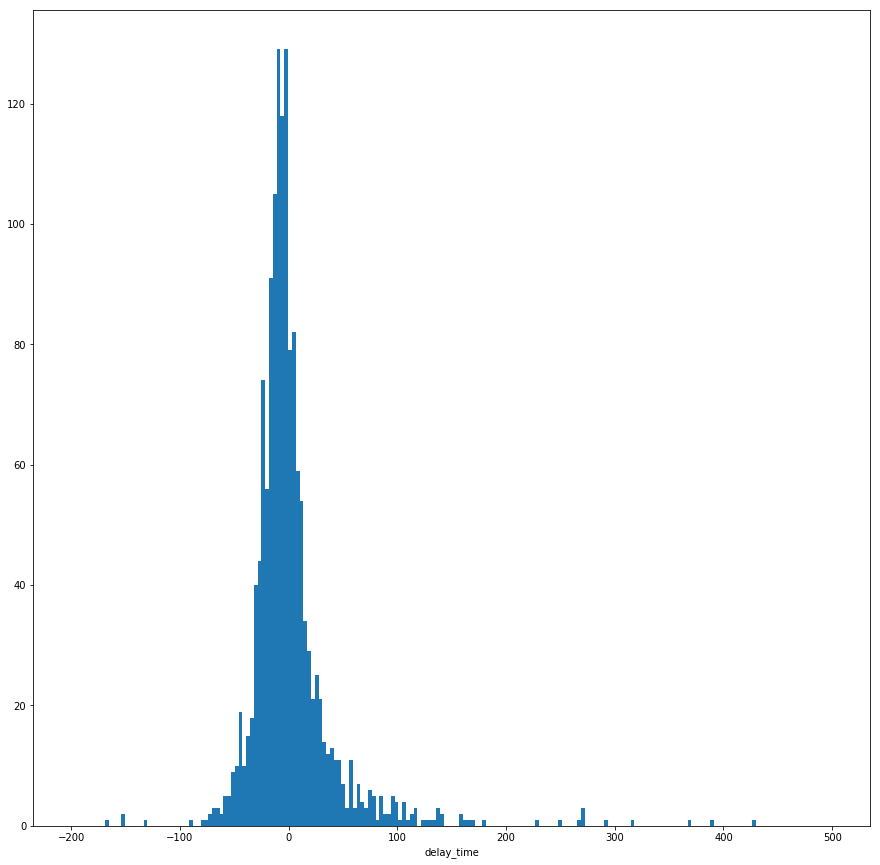

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.hist(delay_vs_weather.total_delay, bins = 200, range=[-200, 500])
ax.set_xlabel('delay_time')

The data looks guassian, so we can model the delay_time variable with a Guassian model

Are there any correlation between the variables?

(-300, 300)

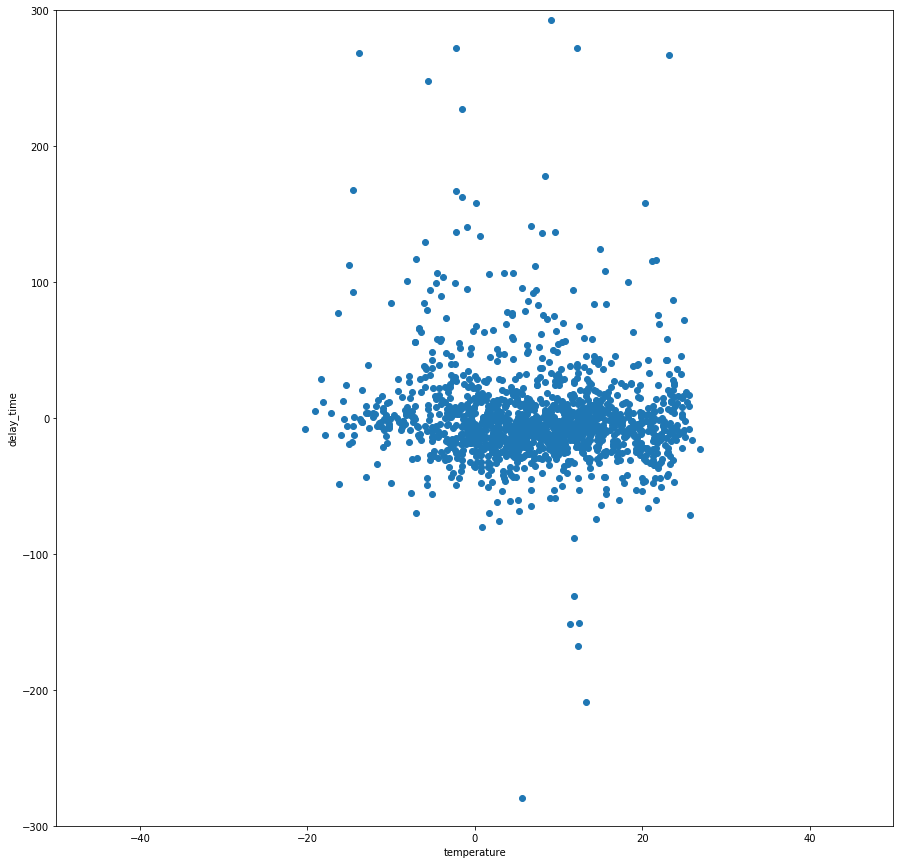

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(delay_vs_weather.temperature, delay_vs_weather.total_delay)
ax.set_ylabel('delay_time')
ax.set_xlabel('temperature')
ax.set_xlim(-50,50)
ax.set_ylim(-300,300)

(-300, 300)

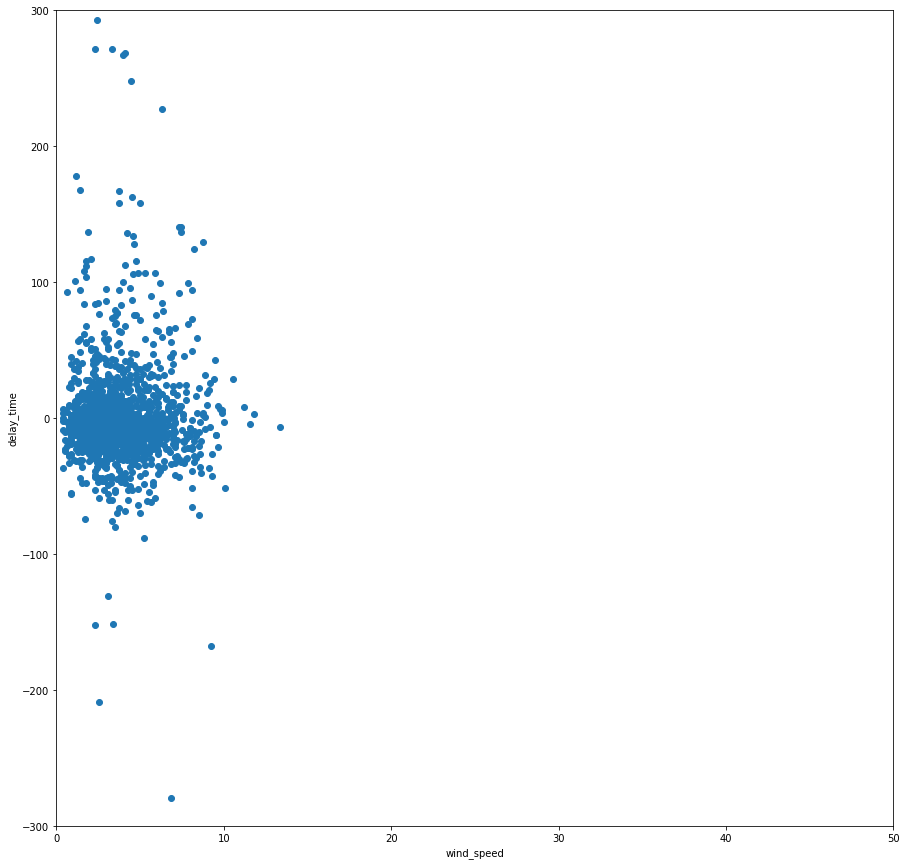

In [289]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(delay_vs_weather.wind_speed, delay_vs_weather.total_delay)
ax.set_ylabel('delay_time')
ax.set_xlabel('wind_speed')
ax.set_xlim(0,50)
ax.set_ylim(-300,300)

The correlation is pretty weak, so we can have priors with small means for both predictor variables

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import BayesianRidge, LinearRegression

In [115]:
clf = BayesianRidge(compute_score=True)
X = delay_vs_weather[['wind_speed', 'temperature']]
y = delay_vs_weather['total_delay']
clf.fit(X, y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [117]:
clf.coef_

array([ 0.00387648, -0.08737176])

In [116]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
scores = cross_val_score(clf, X, y, cv=5, scoring = 'neg_mean_absolute_error')

In [268]:
np.mean(scores)

-30.639427965688963

In [270]:
clf.predict(X)

array([-5.131593  , -5.43327162, -5.74611022, ..., -5.18998747,
       -5.66771414, -5.59296359])

In [19]:
import pymc

In [74]:
delay_time_data = delay_vs_weather['total_delay'].tolist()
wind_speed_data = delay_vs_weather['wind_speed'].tolist()
temp_data = delay_vs_weather['temperature'].tolist()

wind_speed = pymc.Normal('wind_speed', mu=5,tau=1/5,value=wind_speed_data, observed=True)
temp = pymc.Normal('temp', mu=5,tau=1/5,value=temp_data, observed=True)
delay_time = pymc.Normal('output', mu=linear_regress, value=delay_time_data, observed=True)

In [70]:
wind_speed_coeff = pymc.Normal('wind_speed_coeff', mu = 0, tau=1)
temp_coeff = pymc.Normal('temp_coeff', mu=0, tau=1)
intercept = pymc.Normal('intercept', mu=0, tau=1/50)

In [75]:
@pymc.deterministic(plot=False)
def linear_regress(wind_speed=wind_speed, \
                   temp=temp, \
                   wind_speed_coeff=wind_speed_coeff, \
                   temp_coeff=temp_coeff, \
                   intercept=intercept):
    return wind_speed * wind_speed_coeff + temp * temp_coeff + intercept

In [76]:
model = pymc.Model([wind_speed, temp, delay_time, wind_speed_coeff, temp_coeff, intercept])
mcmc = pymc.MCMC(model)
mcmc.sample(iter=100000, burn=10000, thin=10)

 [-----------------100%-----------------] 100000 of 100000 complete in 26.3 sec

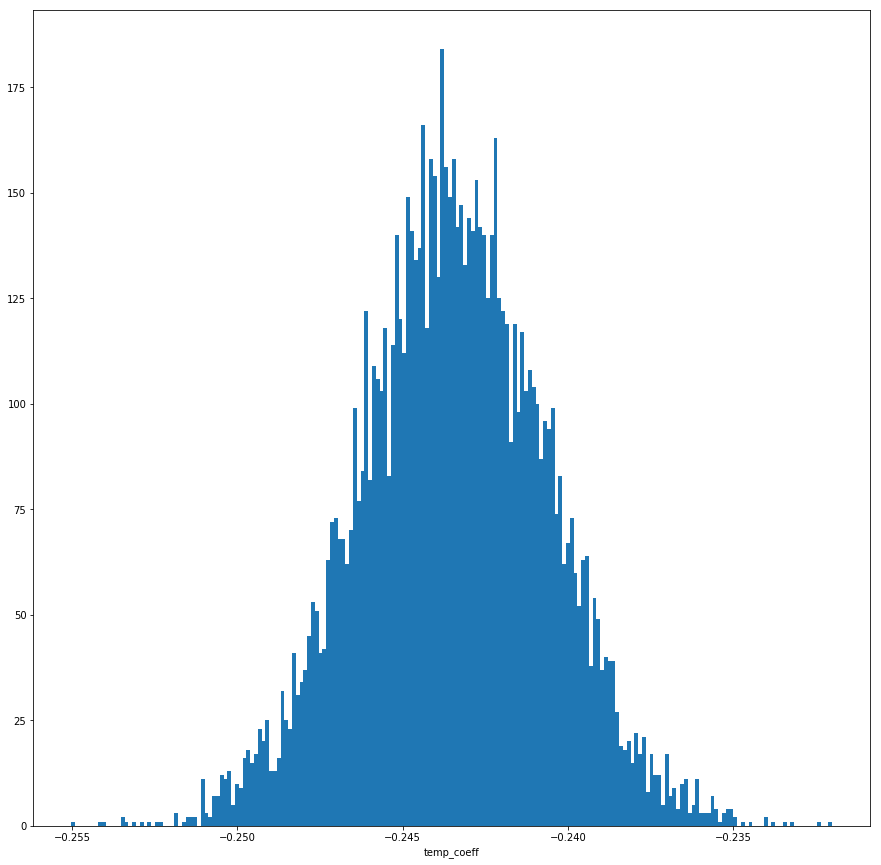

In [107]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.hist(mcmc.trace('temp_coeff')[:], bins = 200)
ax.set_xlabel('temp_coeff')

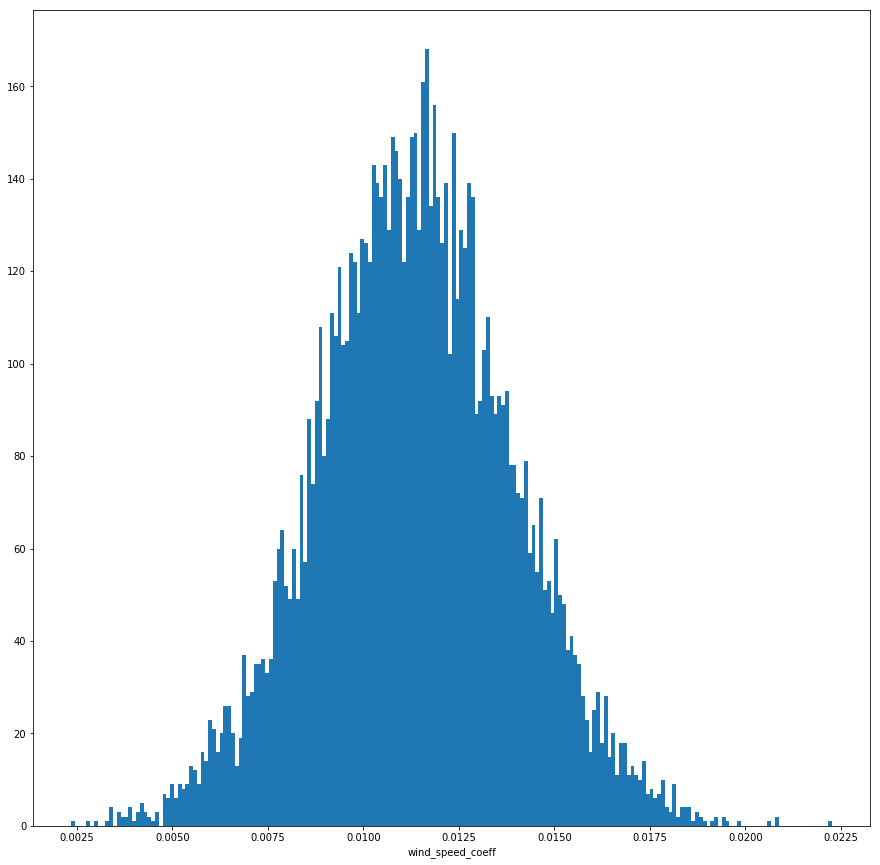

In [109]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.hist(mcmc.trace('wind_speed_coeff')[:], bins = 200)
ax.set_xlabel('wind_speed_coeff')

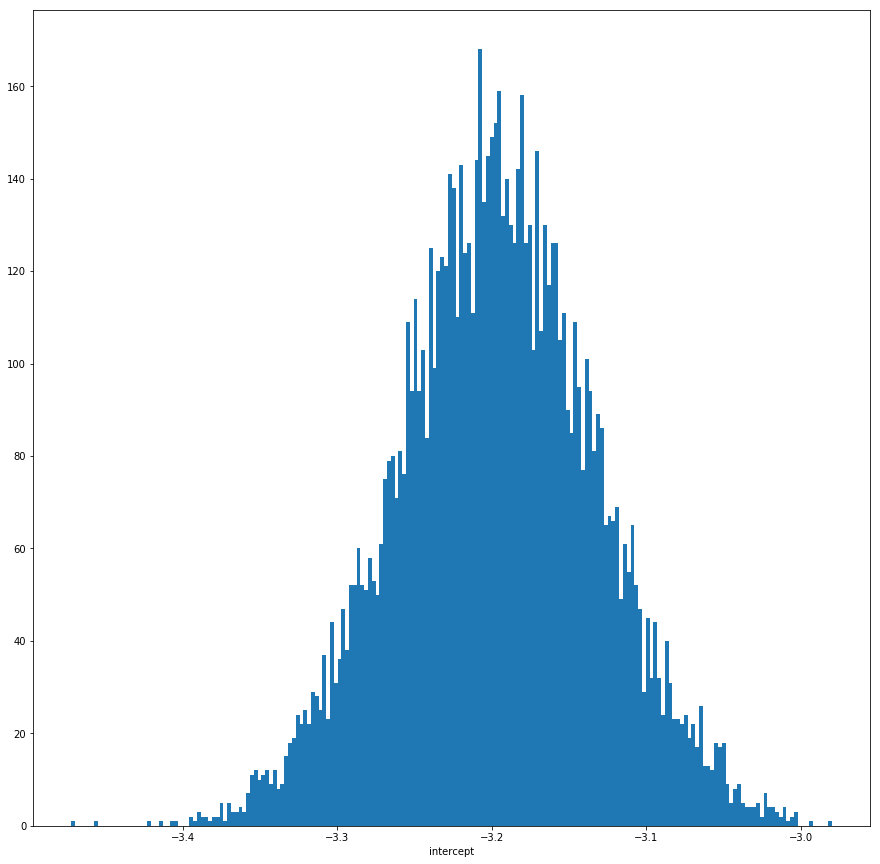

In [111]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.hist(mcmc.trace('intercept')[:], bins = 200)
ax.set_xlabel('intercept')

In [124]:
wind_var = np.var(mcmc.trace('wind_speed_coeff')[:])
temp_var = np.var(mcmc.trace('temp_coeff')[:])
covar = np.cov(mcmc.trace('wind_speed_coeff')[:], mcmc.trace('temp_coeff')[:])

In [ ]:
np.var(mcmc.trace('wind_speed_coeff')[:])